# Constrained Monotonic Neural Networks

> The code is accompaning the paper titled "Constrained Monotonic Neural Networks".

In [1]:
!nvidia-smi

Tue Feb 28 13:01:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from contextlib import contextmanager
from datetime import datetime
from pathlib import Path
from typing import *

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike, NDArray

import pytest
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
from tensorflow.keras.layers import Dense, Embedding, Concatenate, Dropout, BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.types.experimental import TensorLike
from tensorflow.keras.backend import count_params
from tensorflow.keras.optimizers.experimental import AdamW

from keras_tuner import Hyperband, Objective, Tuner


#from tensorflow.python.keras.engine.keras_tensor import KerasTensor

In [4]:
from os import environ

In [5]:
environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

## Data download

Data is downloaded from our S3 bucket. Please do not redistribute the data.

In [6]:
!mkdir data
!cd data; rm *.csv; wget https://monotonicnetworks-submission-data.s3.amazonaws.com/data.zip; unzip data.zip; rm data.zip

!ls -lh data

mkdir: cannot create directory ‘data’: File exists
--2023-02-28 13:01:56--  https://monotonicnetworks-submission-data.s3.amazonaws.com/data.zip
Resolving monotonicnetworks-submission-data.s3.amazonaws.com (monotonicnetworks-submission-data.s3.amazonaws.com)... 52.219.140.178
Connecting to monotonicnetworks-submission-data.s3.amazonaws.com (monotonicnetworks-submission-data.s3.amazonaws.com)|52.219.140.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13805233 (13M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  13.17M  11.0MB/s    in 1.2s    

2023-02-28 13:01:58 (11.0 MB/s) - ‘data.zip’ saved [13805233/13805233]

Archive:  data.zip
  inflating: train_heart.csv         
  inflating: train_auto.csv          
  inflating: test_heart.csv          
  inflating: test_auto.csv           
  inflating: train_compas.csv        
  inflating: test_compas.csv         
  inflating: test_blog.csv           
  inflating: test_loan.

A simple check that we have five training and testing datasets downloaded

In [7]:
data_path = Path("data")
assert data_path.exists(), "Please download the data by runnning the cell above"
train_datasets = list(data_path.glob("train_*.csv"))
test_datasets = list(data_path.glob("test_*.csv"))
assert len(train_datasets) == 5, "There should be five train datasets downloaded"
assert len(test_datasets) == 5, "There should be five test datasets downloaded"

# Monotonic Dense Layer


## Actvation Functions

In [8]:
def get_saturated_activation(
    convex_activation: Callable[[TensorLike], TensorLike],
    concave_activation: Callable[[TensorLike], TensorLike],
    a: float = 1.0,
    c: float = 1.0,
) -> Callable[[TensorLike], TensorLike]:
    def saturated_activation(
        x: TensorLike,
        convex_activation: Callable[[TensorLike], TensorLike]=convex_activation,
        concave_activation: Callable[[TensorLike], TensorLike]=concave_activation,
        a: float=a,
        c: float=c,
    ) -> TensorLike:
        cc = convex_activation(tf.ones_like(x) * c)
        return a * tf.where(
            x <= 0,
            convex_activation(x + c) - cc,
            concave_activation(x - c) + cc,
        )
    
    return saturated_activation

def get_activation_functions(
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None
) -> Tuple[
    Optional[Callable[[TensorLike], TensorLike]],
    Optional[Callable[[TensorLike], TensorLike]],
    Optional[Callable[[TensorLike], TensorLike]],
]:
    if activation:
        convex_activation = tf.keras.activations.get(
            activation.lower() if isinstance(activation, str) else activation
        )
        concave_activation = lambda x: -convex_activation(-x)
        saturated_activation = get_saturated_activation(
            convex_activation, concave_activation
        )
        return convex_activation, concave_activation, saturated_activation
    else:
        return None, None, None

In [9]:
def plot_activation_functions(
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    *,
    font_size: int = 20,
    save_pdf: bool = False,
    save_path: Union[Path, str] = "plots",
    linestyle="--", 
    alpha=0.7,
    linewidth=4.0
) -> None:
    font = {"size": font_size}
    matplotlib.rc("font", **font)
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)
    plt.rcParams["figure.figsize"] = (6, 4)

    x = np.arange(-3.5, 3.5, 0.1)
    plot_kwargs = dict(linestyle=linestyle, alpha=alpha, linewidth=linewidth)
    plt.plot(x, convex_activation(x), label=r"$\breve{\rho}(x)$", **plot_kwargs)
    plt.plot(x, concave_activation(x), label=r"$\hat{\rho}(x)$", **plot_kwargs)
    plt.plot(x, saturated_activation(x), label=r"$\tilde{\rho}(x)$", **plot_kwargs)
    plt.legend()

    title = f"{activation.__name__ if hasattr(activation, '__name__') else activation}-based activations"
    plt.title(title)
    if save_pdf:
        path = Path(save_path) / (title.replace(" ", "_") + ".pdf")
        path.parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(path, format="pdf")
#         print(f"Saved figure to: {path}")

    plt.show()

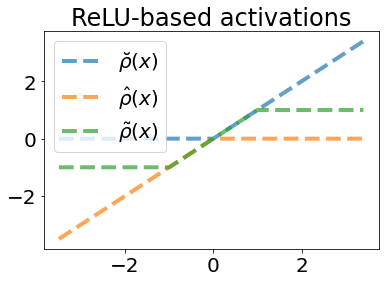

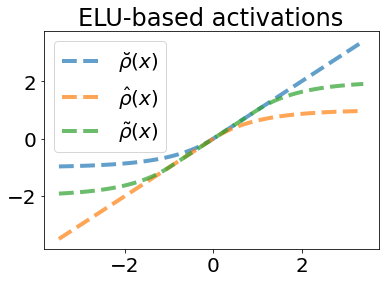

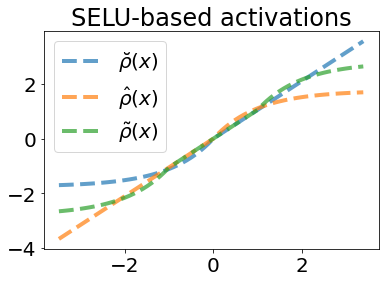

In [10]:

for activation in ["ReLU", "ELU", "SELU"]:
    plot_activation_functions(activation, save_pdf=True)

In [11]:
@tf.function
def apply_activations(
    x: TensorLike,
    *,
    units,
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    is_convex: bool = False,
    is_concave: bool = False,
    activation_weights: Tuple[float, float, float] = (7.0, 7.0, 2.0),
) -> TensorLike:
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)
    
    if convex_activation is None:
        return x
    
    elif is_convex:
        normalized_activation_weights = np.array([1., 0., 0.])
    elif is_concave:
        normalized_activation_weights = np.array([0., 1., 0.])
    else:
        if len(activation_weights) != 3:
            raise ValueError(f"activation_weights={activation_weights}")
        if (np.array(activation_weights) < 0).any():
            raise ValueError(f"activation_weights={activation_weights}")
        normalized_activation_weights = np.array(activation_weights) / sum(activation_weights)
        
    s_convex = round(normalized_activation_weights[0]*units)
    s_concave = round(normalized_activation_weights[1]*units)
    s_saturated = units - s_convex - s_concave

    x_convex, x_concave, x_saturated = tf.split(x, (s_convex, s_concave, s_saturated), axis=-1)

    y_convex = convex_activation(x_convex)
    y_concave = concave_activation(x_concave)
    y_saturated = saturated_activation(x_saturated)

    y = tf.concat([y_convex, y_concave, y_saturated], axis=-1)

    return y

In [12]:
def plot_applied_activation(
    activation: str = "relu",
    *,
    save_pdf: bool = False,
    save_path: Union[Path, str] = "plots",
    font_size: int = 20,
    linestyle="--",
    alpha=0.7,
    linewidth=2.0,
):
    font = {"size": font_size}
    matplotlib.rc("font", **font)
    plt.rcParams["figure.figsize"] = (18, 3)

    x = np.arange(-1.5, 1.5, step=3 / 256)
    h = 3 * np.sin(2 * np.pi * x)

    y = apply_activations(h, activation=activation, units=x.shape[0], activation_weights=(1., 1., 1.))

    plot_kwargs = dict(linestyle=linestyle, alpha=alpha, linewidth=linewidth)

    plt.plot(np.arange(x.shape[0]), h, label="$h$", **plot_kwargs)
    plt.plot(np.arange(x.shape[0]), y, label=r"${\rho}(h)$", **plot_kwargs)
    title = (
        "Applying "
        + (activation.__name__ if hasattr(activation, "__name__") else activation)
        + f"-based activations to {x.shape[0]}-dimensional vector" + r" $h$"
    )
    plt.title(title)

    plt.legend()

    if save_pdf:
        path = Path(save_path) / (title.replace(" ", "_") + ".pdf")
        path.parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(path, format="pdf")
    #         print(f"Saved figure to: {path}")

    plt.show()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


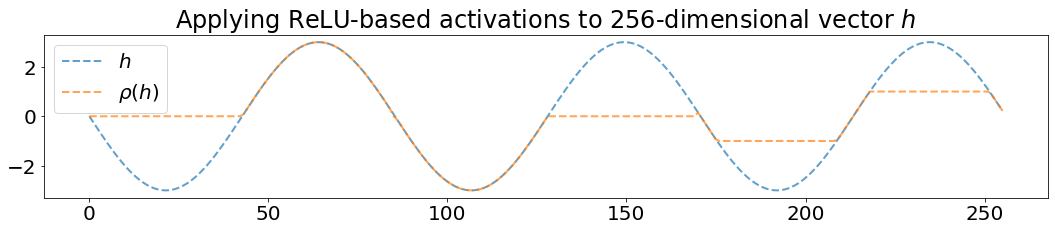

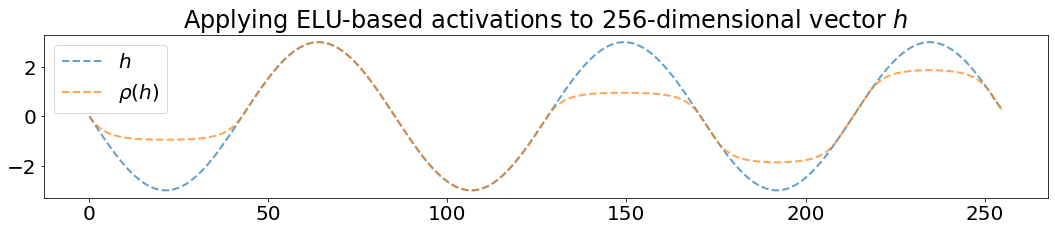

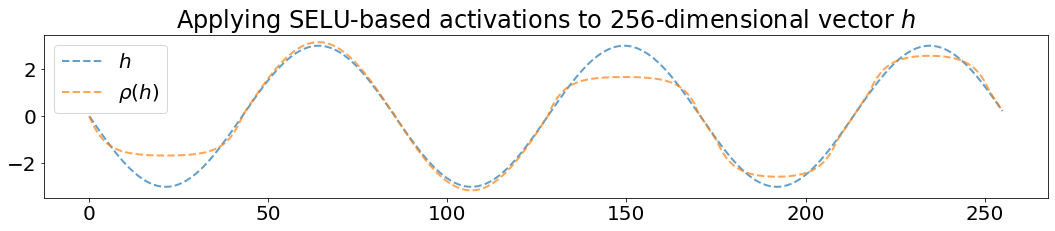

In [13]:
for activation in ["ReLU", "ELU", "SELU"]:
    plot_applied_activation(activation, save_pdf=True)

## Monotonicity indicator


In [14]:
def get_monotonicity_indicator(
    monotonicity_indicator: ArrayLike,
    *,
    input_shape: Tuple[int, ...],
    units: int,
) -> TensorLike:
    # convert to tensor if needed and make it broadcastable to the kernel
    monotonicity_indicator = np.array(monotonicity_indicator)
    if len(monotonicity_indicator.shape) < 2:
        monotonicity_indicator = np.reshape(monotonicity_indicator, (-1, 1))
    elif len(monotonicity_indicator.shape) > 2:
        raise ValueError(
            f"monotonicity_indicator has rank greater than 2: {monotonicity_indicator.shape}"
        )

    monotonicity_indicator_broadcasted = np.broadcast_to(
        monotonicity_indicator, shape=(input_shape[-1], units)
    )

    if not np.all(
        (monotonicity_indicator == -1)
        | (monotonicity_indicator == 0)
        | (monotonicity_indicator == 1)
    ):
        raise ValueError(
            f"Each element of monotonicity_indicator must be one of -1, 0, 1, but it is: '{monotonicity_indicator}'"
        )
    return monotonicity_indicator

In [15]:
input_shape = (13, 2)
units = 3

layer = Dense(units=units)
layer.build(input_shape=input_shape)

for monotonicity_indicator in [
    1,
    [1],
    [1, 1],
    np.ones((2,)),
    np.ones((2, 1)),
    np.ones((2, 3)),
]:
    expected = np.ones((2, 3))
    actual = get_monotonicity_indicator(
        monotonicity_indicator, input_shape=(13, 2), units=3
    )

    # rank is 2
    assert len(actual.shape) == 2
    # it is broadcastable to the kernel shape of (input_shape[-1], units)
    np.testing.assert_array_equal(np.broadcast_to(actual, (2, 3)), expected)


In [16]:
expected = [[1], [0], [-1]]
actual = get_monotonicity_indicator([1, 0, -1], input_shape=(13, 3), units=4)
np.testing.assert_array_equal(actual, expected)

In [17]:
with pytest.raises(ValueError) as e:
    get_monotonicity_indicator([0, 1, -1], input_shape=(13, 2), units=3)
assert e.value.args == (
    "operands could not be broadcast together with remapped shapes [original->remapped]: (3,1)  and requested shape (2,3)",
)

In [18]:
def apply_monotonicity_indicator_to_kernel(
    kernel: tf.Variable,
    monotonicity_indicator: ArrayLike,
) -> TensorLike:

#     # convert to tensor if needed and make it broadcastable to the kernel
    monotonicity_indicator = tf.convert_to_tensor(monotonicity_indicator)

    # absolute value of the kernel
    abs_kernel = tf.abs(kernel)

    # replace original kernel values for positive or negative ones where needed
    xs = tf.where(
        monotonicity_indicator == 1,
        abs_kernel,
        kernel,
    )
    xs = tf.where(monotonicity_indicator == -1, -abs_kernel, xs)

    return xs


@contextmanager
def replace_kernel_using_monotonicity_indicator(
    layer: tf.keras.layers.Dense,
    monotonicity_indicator: Union[int, NDArray[np.int_]],
#     *,
#     input_shape: Tuple,
#     units: int,
) -> Generator[None, None, None]:
    old_kernel = layer.kernel

    layer.kernel = apply_monotonicity_indicator_to_kernel(
        layer.kernel, monotonicity_indicator#, input_shape=input_shape, units=units
    )
    try:
        yield
    finally:
        layer.kernel = old_kernel

In [19]:
def display_kernel(kernel: Union[tf.Variable, np.typing.NDArray[float]]) -> None:
    cm = sns.color_palette("coolwarm_r", as_cmap=True)

    df = pd.DataFrame(kernel)
    
    display(df.style.format("{:.2f}").background_gradient(cmap=cm, vmin=-1e-8, vmax=1e-8))

In [20]:
tf.keras.utils.set_random_seed(42)

units = 18
input_len = 7

layer = tf.keras.layers.Dense(units=units)

input_shape = (input_len,)
layer.build(input_shape=input_shape)

print("Original kernel:")
display_kernel(layer.kernel)

print("Kernel after applying monotocity indicator 1 for all values:")
monotonicity_indicator = get_monotonicity_indicator(
    1, input_shape=input_shape, units=units
)
with replace_kernel_using_monotonicity_indicator(layer, monotonicity_indicator):
    display_kernel(layer.kernel)

Original kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.35,0.16,-0.14,0.44,-0.41,0.15,0.46,-0.33,0.02,0.13,-0.41,-0.05,0.46,-0.03,0.00,0.26,-0.47,-0.30
1,0.01,-0.42,-0.45,0.34,0.41,-0.23,0.35,-0.36,-0.04,0.06,0.07,-0.29,-0.28,0.48,-0.38,-0.06,-0.23,-0.37
2,0.23,-0.31,0.18,0.15,-0.45,0.06,-0.16,-0.11,0.45,-0.09,0.03,-0.24,-0.37,0.21,0.11,0.01,-0.46,-0.37
3,0.29,0.36,-0.07,-0.18,-0.46,-0.45,0.25,0.32,-0.12,0.22,-0.18,0.27,-0.18,-0.07,0.35,0.32,0.18,0.39
4,0.35,-0.27,0.13,-0.40,0.44,0.21,0.06,-0.31,-0.30,0.46,-0.44,-0.18,-0.26,-0.34,0.36,0.33,0.12,0.04
5,0.04,0.21,-0.02,-0.36,0.39,-0.13,0.30,0.35,-0.12,-0.43,0.44,0.32,0.06,-0.30,-0.29,0.24,-0.44,-0.13
6,0.38,-0.04,-0.30,0.17,-0.03,0.37,-0.03,-0.18,0.42,-0.39,-0.33,-0.19,0.02,-0.41,-0.44,0.42,0.38,-0.21


Kernel after applying monotocity indicator 1 for all values:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.35,0.16,0.14,0.44,0.41,0.15,0.46,0.33,0.02,0.13,0.41,0.05,0.46,0.03,0.00,0.26,0.47,0.30
1,0.01,0.42,0.45,0.34,0.41,0.23,0.35,0.36,0.04,0.06,0.07,0.29,0.28,0.48,0.38,0.06,0.23,0.37
2,0.23,0.31,0.18,0.15,0.45,0.06,0.16,0.11,0.45,0.09,0.03,0.24,0.37,0.21,0.11,0.01,0.46,0.37
3,0.29,0.36,0.07,0.18,0.46,0.45,0.25,0.32,0.12,0.22,0.18,0.27,0.18,0.07,0.35,0.32,0.18,0.39
4,0.35,0.27,0.13,0.40,0.44,0.21,0.06,0.31,0.30,0.46,0.44,0.18,0.26,0.34,0.36,0.33,0.12,0.04
5,0.04,0.21,0.02,0.36,0.39,0.13,0.30,0.35,0.12,0.43,0.44,0.32,0.06,0.30,0.29,0.24,0.44,0.13
6,0.38,0.04,0.30,0.17,0.03,0.37,0.03,0.18,0.42,0.39,0.33,0.19,0.02,0.41,0.44,0.42,0.38,0.21


In [21]:
monotonicity_indicator = [1] * 2 + [-1] * 2 + [0] * (input_shape[0] - 4)
monotonicity_indicator = get_monotonicity_indicator(
    monotonicity_indicator, input_shape=input_shape, units=units
)

print("Monotocity indicator:")
display_kernel(monotonicity_indicator)

print("Kernel after applying the monotocity indicator:")
with replace_kernel_using_monotonicity_indicator(
    layer, monotonicity_indicator
):
    display_kernel(layer.kernel)

Monotocity indicator:


,0
0,1.00
1,1.00
2,-1.00
3,-1.00
4,0.00
5,0.00
6,0.00


Kernel after applying the monotocity indicator:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.35,0.16,0.14,0.44,0.41,0.15,0.46,0.33,0.02,0.13,0.41,0.05,0.46,0.03,0.00,0.26,0.47,0.30
1,0.01,0.42,0.45,0.34,0.41,0.23,0.35,0.36,0.04,0.06,0.07,0.29,0.28,0.48,0.38,0.06,0.23,0.37
2,-0.23,-0.31,-0.18,-0.15,-0.45,-0.06,-0.16,-0.11,-0.45,-0.09,-0.03,-0.24,-0.37,-0.21,-0.11,-0.01,-0.46,-0.37
3,-0.29,-0.36,-0.07,-0.18,-0.46,-0.45,-0.25,-0.32,-0.12,-0.22,-0.18,-0.27,-0.18,-0.07,-0.35,-0.32,-0.18,-0.39
4,0.35,-0.27,0.13,-0.40,0.44,0.21,0.06,-0.31,-0.30,0.46,-0.44,-0.18,-0.26,-0.34,0.36,0.33,0.12,0.04
5,0.04,0.21,-0.02,-0.36,0.39,-0.13,0.30,0.35,-0.12,-0.43,0.44,0.32,0.06,-0.30,-0.29,0.24,-0.44,-0.13
6,0.38,-0.04,-0.30,0.17,-0.03,0.37,-0.03,-0.18,0.42,-0.39,-0.33,-0.19,0.02,-0.41,-0.44,0.42,0.38,-0.21


## Monotonic Dense Layer

This is an implementation of our Monotonic Dense Unit or Constrained Monotone Fully Connected Layer. The below is the figure from the paper for reference.

In the code, the variable `monotonicity_indicator` corresponds to **t** in the figure and the variable `activation_selector` corresponds to **s**. 

Parameters `convexity_indicator` and `epsilon` are used to calculate `activation_selector` as follows:
- if `convexity_indicator` is  -1 or 1, then `activation_selector` will have all elements 0 or 1, respecively.
- if `convexity_indicator` is `None`, then `epsilon` must have a value between 0 and 1 and corresponds to the percentage of elements of `activation_selector` set to 1.

![Screenshot%202023-01-26%20at%2015.10.50.png](attachment:Screenshot%202023-01-26%20at%2015.10.50.png)

In [22]:
class MonotonicDense(Dense):
    """Monotonic counterpart of the regular Dense Layer of tf.keras"""

    def __init__(
        self,
        units: int,
        *,
        activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
        monotonicity_indicator: ArrayLike = 1,
        is_convex: bool = False,
        is_concave: bool = False,
        activation_weights: Tuple[float, float, float] = (7.0, 7.0, 2.0),
        **kwargs,
    ) -> TensorLike:
        """Constructs a new MonotonicDense instance.

        Params:
            units: Positive integer, dimensionality of the output space.
            activation: Activation function to use, it is assumed to be convex monotonically
                increasing function such as "relu" or "elu"
            monotonicity_indicator: Vector to indicate which of the inputs are monotonically increasing or
                monotonically decreasing or non-monotonic. Has value 1 for monotonically increasing,
                -1 for monotonically decreasing and 0 for non-monotonic.
            is_convex: convex if set to True
            is_concave: concave if set to True
            activation_weights: relative weights for each type of activation, the default is (1.0, 1.0, 1.0).
                Ignored if is_convex or is_concave is set to True
            **kwargs: passed as kwargs to the constructor of `Dense`

        Raise:
            ValueError:
                - if both **is_concave** and **is_convex** are set to **True**, or
                - if any component of activation_weights is negative or there is not exactly three components
        """
        if is_convex and is_concave:
            raise ValueError(
                "The model cannot be set to be both convex and concave (only linear functions are both)."
            )

        if len(activation_weights) != 3:
            raise ValueError(
                f"There must be exactly three components of activation_weights, but we have this instead: {activation_weights}."
            )

        if (np.array(activation_weights) < 0).any():
            raise ValueError(
                f"Values of activation_weights must be non-negative, but we have this instead: {activation_weights}."
            )

        super(MonotonicDense, self).__init__(units=units, activation=None, **kwargs)

        self.units = units
        self.org_activation = activation
        self.activation_weights = activation_weights
        self.monotonicity_indicator = monotonicity_indicator
        self.is_convex = is_convex
        self.is_concave = is_concave

    def build(self, input_shape: Tuple, *args: List[Any], **kwargs: Dict[str, Any]) -> None:
        """Build

        Args:
            input_shape: input tensor
            args: positional arguments passed to Dense.build()
            kwargs: keyword arguments passed to Dense.build()
        """
        super(MonotonicDense, self).build(input_shape, *args, **kwargs)
        self.monotonicity_indicator = get_monotonicity_indicator(
            monotonicity_indicator=self.monotonicity_indicator,
            input_shape=input_shape,
            units=self.units,
        )

    def call(self, inputs: TensorLike) -> TensorLike:
        """Call

        Args:
            inputs: input tensor of shape (batch_size, ..., x_length)
            
        Returns:
            N-D tensor with shape: `(batch_size, ..., units)`.

        """
        # calculate W'*x+y after we replace the kernal according to monotonicity vector
        with replace_kernel_using_monotonicity_indicator(self, monotonicity_indicator=self.monotonicity_indicator):
            h = super(MonotonicDense, self).call(inputs)

        y = apply_activations(
            h,
            units=self.units,
            activation=self.org_activation,
            is_convex=self.is_convex,
            is_concave=self.is_concave,
            activation_weights=self.activation_weights,
        )

        return y

In [23]:
units = 18
activation = "relu"
batch_size = 9
x_len = 11

x = np.random.default_rng(42).normal(size=(batch_size, x_len))

tf.keras.utils.set_random_seed(42)

for monotonicity_indicator in [[1]*4+[0]*4+[-1]*3, 1, np.ones((x_len,)), -1, -np.ones((x_len,))]:
    print("*"*120)    
    mono_layer = MonotonicDense(
        units=units,
        activation=activation,
        monotonicity_indicator=monotonicity_indicator,
        activation_weights=(7, 7, 4),
    )
    y = mono_layer(x)
    print(f"monotonicity_indicator = {monotonicity_indicator}")
    display_kernel(mono_layer.monotonicity_indicator)
    
    print("kernel:")
    with replace_kernel_using_monotonicity_indicator(
        mono_layer, mono_layer.monotonicity_indicator
    ):
        display_kernel(mono_layer.kernel)
        
    print("output:")
    display_kernel(y)
print("ok") 

************************************************************************************************************************
monotonicity_indicator = [1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1]


,0
0,1.00
1,1.00
2,1.00
3,1.00
4,0.00
5,0.00
6,0.00
7,0.00
8,-1.00
9,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.33,0.15,0.13,0.41,0.38,0.14,0.43,0.30,0.02,0.12,0.38,0.05,0.42,0.03,0.00,0.24,0.44,0.28
1,0.01,0.39,0.42,0.32,0.38,0.22,0.33,0.34,0.03,0.06,0.06,0.27,0.26,0.45,0.35,0.05,0.21,0.34
2,0.21,0.29,0.16,0.14,0.42,0.06,0.15,0.10,0.41,0.08,0.03,0.22,0.34,0.20,0.11,0.01,0.43,0.35
3,0.27,0.33,0.06,0.17,0.42,0.42,0.24,0.30,0.11,0.20,0.17,0.25,0.17,0.07,0.32,0.30,0.17,0.36
4,0.32,-0.25,0.12,-0.37,0.41,0.20,0.06,-0.28,-0.27,0.43,-0.41,-0.17,-0.24,-0.31,0.33,0.31,0.11,0.03
5,0.04,0.19,-0.02,-0.34,0.36,-0.12,0.28,0.32,-0.11,-0.40,0.41,0.30,0.06,-0.28,-0.27,0.23,-0.41,-0.12
6,0.35,-0.04,-0.28,0.16,-0.03,0.35,-0.03,-0.16,0.39,-0.36,-0.31,-0.18,0.02,-0.38,-0.40,0.39,0.35,-0.19
7,0.33,-0.34,0.11,-0.29,0.25,-0.21,0.11,0.08,-0.19,-0.39,0.01,0.10,0.39,-0.25,-0.37,-0.27,0.04,0.34
8,-0.27,-0.09,-0.02,-0.45,-0.16,-0.12,-0.09,-0.43,-0.36,-0.09,-0.23,-0.42,-0.28,-0.24,-0.30,-0.31,-0.07,-0.07
9,-0.38,-0.34,-0.44,-0.42,-0.32,-0.06,-0.27,-0.28,-0.22,-0.05,-0.08,-0.07,-0.21,-0.39,-0.01,-0.26,-0.24,-0.42


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.01,0.40,0.00,1.38,0.00,0.10,0.00,-0.00,-0.00,-0.13,-0.00,-0.26,-0.00,-0.00,-0.55,-0.52,0.79,0.64
1,0.45,1.02,0.96,0.71,1.22,0.00,0.86,-0.00,-0.00,-0.09,-0.00,-0.00,-0.00,-0.00,0.26,-0.17,0.54,1.00
2,0.30,0.00,0.33,0.00,0.41,0.00,0.42,-0.53,-0.89,-0.29,-0.23,-0.84,-0.16,-0.93,-0.90,0.08,0.37,0.08
3,0.21,0.26,0.33,0.42,0.00,0.00,0.00,-0.16,-0.00,-0.61,-0.53,-0.07,-0.00,-0.00,-0.55,-0.66,0.83,0.78
4,1.38,0.49,0.70,0.82,1.47,0.54,0.63,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.73,0.97,0.94,0.91
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.86,-0.25,-0.00,-1.57,-1.19,-0.61,-0.23,0.13,-1.00,0.50,-0.06
6,0.00,0.00,0.00,0.17,0.00,0.00,0.00,-0.15,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.06,-1.00,0.00,0.12
7,0.00,0.96,0.35,0.93,0.00,0.32,0.17,-0.00,-0.00,-0.00,-0.00,-0.00,-0.17,-0.00,0.67,0.06,0.12,0.17
8,0.00,1.33,0.92,1.63,0.52,0.00,0.66,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.23,0.18,0.81


************************************************************************************************************************
monotonicity_indicator = 1


,0
0,1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.44,0.02,0.24,0.22,0.29,0.35,0.18,0.03,0.39,0.17,0.25,0.02,0.10,0.13,0.00,0.42,0.21,0.31
1,0.35,0.06,0.26,0.42,0.05,0.41,0.16,0.33,0.03,0.26,0.11,0.03,0.23,0.04,0.37,0.27,0.32,0.40
2,0.37,0.30,0.36,0.14,0.21,0.40,0.01,0.28,0.16,0.44,0.43,0.23,0.27,0.22,0.23,0.25,0.43,0.05
3,0.32,0.25,0.05,0.45,0.08,0.18,0.26,0.24,0.34,0.07,0.07,0.14,0.04,0.19,0.29,0.23,0.43,0.09
4,0.36,0.05,0.20,0.41,0.38,0.29,0.01,0.44,0.17,0.04,0.31,0.34,0.29,0.16,0.25,0.18,0.01,0.28
5,0.34,0.31,0.38,0.34,0.08,0.40,0.15,0.16,0.14,0.25,0.15,0.20,0.10,0.06,0.44,0.19,0.42,0.21
6,0.01,0.38,0.43,0.18,0.00,0.43,0.45,0.28,0.25,0.18,0.03,0.26,0.22,0.26,0.08,0.23,0.45,0.42
7,0.04,0.12,0.28,0.17,0.11,0.00,0.15,0.24,0.05,0.05,0.27,0.32,0.33,0.11,0.09,0.40,0.19,0.06
8,0.30,0.17,0.21,0.42,0.21,0.29,0.19,0.38,0.03,0.34,0.32,0.30,0.34,0.15,0.28,0.11,0.44,0.19
9,0.10,0.10,0.35,0.32,0.24,0.28,0.30,0.28,0.10,0.12,0.30,0.41,0.15,0.00,0.10,0.40,0.18,0.24


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.93,-0.00,-0.07,-0.58,-0.88,-0.58,-0.00,-0.87,-0.49,-0.05,-1.00
1,0.73,0.10,0.22,0.18,0.18,0.16,0.00,-0.23,-0.00,-0.00,-0.00,-0.09,-0.00,-0.00,0.16,0.47,0.53,-0.27
2,1.15,0.36,0.82,1.20,0.80,1.06,0.61,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.53,0.61,1.00,0.94
3,0.00,0.45,0.28,0.00,0.00,0.11,0.14,-0.00,-0.21,-0.00,-0.00,-0.00,-0.00,-0.00,0.15,0.08,0.72,-0.08
4,0.34,0.19,0.36,0.05,0.15,0.30,0.00,-0.00,-0.00,-0.08,-0.00,-0.00,-0.00,-0.00,0.06,0.38,0.04,0.14
5,0.00,0.00,0.26,0.00,0.67,0.05,0.00,-0.00,-0.16,-0.00,-0.00,-0.00,-0.00,-0.00,-0.08,0.30,-0.17,-0.17
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.76,-0.68,-0.28,-0.11,-0.37,-0.42,-0.40,-0.88,-0.41,-0.67,-1.00
7,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-0.45,-0.17,-0.04,-0.57,-0.82,-0.50,-0.22,-0.07,-0.62,-0.13,-0.18
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.32,-0.35,-0.39,-0.77,-1.63,-1.12,-0.60,-0.47,-0.99,-1.00,-1.00


************************************************************************************************************************
monotonicity_indicator = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


,0
0,1.00
1,1.00
2,1.00
3,1.00
4,1.00
5,1.00
6,1.00
7,1.00
8,1.00
9,1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.31,0.02,0.11,0.29,0.10,0.33,0.37,0.06,0.39,0.35,0.15,0.13,0.15,0.45,0.07,0.19,0.03,0.06
1,0.12,0.02,0.06,0.41,0.32,0.24,0.34,0.28,0.22,0.06,0.33,0.27,0.25,0.23,0.43,0.09,0.45,0.27
2,0.19,0.11,0.19,0.25,0.07,0.42,0.32,0.35,0.15,0.05,0.00,0.24,0.22,0.39,0.44,0.11,0.19,0.10
3,0.15,0.37,0.21,0.41,0.25,0.04,0.37,0.04,0.05,0.22,0.31,0.35,0.35,0.08,0.38,0.01,0.25,0.29
4,0.17,0.45,0.24,0.32,0.01,0.00,0.19,0.34,0.17,0.19,0.18,0.34,0.02,0.24,0.03,0.41,0.26,0.00
5,0.29,0.10,0.07,0.34,0.04,0.30,0.39,0.27,0.39,0.16,0.33,0.45,0.06,0.19,0.23,0.04,0.36,0.04
6,0.13,0.15,0.22,0.40,0.14,0.30,0.11,0.45,0.14,0.17,0.26,0.16,0.36,0.10,0.17,0.32,0.14,0.08
7,0.25,0.25,0.24,0.45,0.17,0.45,0.30,0.35,0.41,0.40,0.11,0.26,0.32,0.08,0.22,0.34,0.05,0.09
8,0.16,0.27,0.10,0.23,0.08,0.21,0.19,0.16,0.06,0.04,0.17,0.05,0.39,0.11,0.26,0.25,0.13,0.05
9,0.17,0.17,0.00,0.13,0.12,0.03,0.39,0.11,0.01,0.29,0.43,0.20,0.21,0.43,0.39,0.18,0.19,0.27


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.00,0.00,0.08,0.00,0.00,0.00,0.00,-0.82,-0.58,-0.32,-1.07,-1.09,-0.00,-0.63,-0.21,-0.74,-1.00,-0.15
1,0.36,0.00,0.00,0.51,0.11,0.72,0.76,-0.12,-0.00,-0.00,-0.05,-0.00,-0.00,-0.00,0.56,-0.34,0.13,0.22
2,0.72,0.68,0.32,1.10,0.10,0.84,0.68,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.20,0.97,0.33,-0.07
3,0.00,0.00,0.36,0.35,0.36,0.82,0.00,-0.00,-0.00,-0.19,-0.29,-0.13,-0.00,-0.20,0.67,0.20,-0.00,0.14
4,0.18,0.14,0.26,0.68,0.09,0.38,0.36,-0.00,-0.00,-0.00,-0.00,-0.00,-0.07,-0.00,0.14,0.15,0.33,0.10
5,0.01,0.55,0.50,0.00,0.00,0.21,0.00,-0.00,-0.27,-0.00,-0.44,-0.25,-0.00,-0.00,0.44,0.83,-0.24,-0.01
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.89,-0.85,-0.48,-0.77,-0.90,-0.21,-0.30,-0.09,-0.69,-0.83,-0.03
7,0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.78,-0.59,-0.65,-0.21,-0.55,-0.19,-0.37,-0.17,-0.71,-0.10,0.03
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.24,-0.48,-0.95,-1.13,-0.71,-1.40,-0.30,-0.76,-1.00,-0.47,-0.39


************************************************************************************************************************
monotonicity_indicator = -1


,0
0,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.29,-0.12,-0.00,-0.17,-0.33,-0.17,-0.33,-0.36,-0.28,-0.16,-0.24,-0.22,-0.10,-0.13,-0.02,-0.38,-0.23,-0.02
1,-0.36,-0.13,-0.05,-0.07,-0.41,-0.30,-0.38,-0.06,-0.40,-0.42,-0.44,-0.03,-0.27,-0.03,-0.32,-0.31,-0.35,-0.40
2,-0.30,-0.07,-0.40,-0.06,-0.10,-0.21,-0.16,-0.22,-0.06,-0.36,-0.40,-0.42,-0.23,-0.22,-0.20,-0.33,-0.45,-0.06
3,-0.05,-0.08,-0.07,-0.30,-0.44,-0.23,-0.40,-0.25,-0.13,-0.31,-0.11,-0.13,-0.13,-0.34,-0.15,-0.05,-0.36,-0.13
4,-0.45,-0.34,-0.41,-0.39,-0.15,-0.10,-0.40,-0.32,-0.19,-0.13,-0.29,-0.39,-0.43,-0.29,-0.13,-0.05,-0.39,-0.01
5,-0.09,-0.38,-0.00,-0.12,-0.07,-0.42,-0.01,-0.12,-0.26,-0.28,-0.16,-0.06,-0.08,-0.43,-0.23,-0.28,-0.28,-0.07
6,-0.34,-0.38,-0.15,-0.44,-0.41,-0.19,-0.25,-0.41,-0.34,-0.22,-0.43,-0.36,-0.25,-0.28,-0.06,-0.12,-0.15,-0.16
7,-0.17,-0.39,-0.40,-0.26,-0.40,-0.20,-0.10,-0.14,-0.42,-0.21,-0.18,-0.25,-0.15,-0.21,-0.13,-0.41,-0.14,-0.14
8,-0.38,-0.03,-0.10,-0.21,-0.13,-0.04,-0.19,-0.00,-0.09,-0.38,-0.01,-0.27,-0.24,-0.24,-0.13,-0.18,-0.37,-0.21
9,-0.43,-0.08,-0.20,-0.29,-0.10,-0.27,-0.08,-0.43,-0.22,-0.37,-0.27,-0.24,-0.15,-0.22,-0.01,-0.45,-0.35,-0.31


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.05,0.88,0.59,0.61,0.00,0.70,0.64,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.24,0.74,1.00,0.55
1,0.27,0.26,0.00,0.41,0.00,0.00,0.00,-0.00,-0.23,-0.34,-0.21,-0.20,-0.00,-0.02,-0.04,-0.82,-0.52,-0.02
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.36,-0.77,-0.71,-0.39,-1.00,-0.82,-0.67,-0.11,-0.74,-0.97,-0.31
3,0.00,0.00,0.00,0.00,0.00,0.01,0.00,-0.00,-0.16,-0.50,-0.38,-0.33,-0.20,-0.00,-0.39,-0.20,-0.12,-0.36
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.45,-0.46,-0.00,-0.84,-0.48,-0.36,-0.13,-0.08,-0.28,-0.33,0.13
5,0.00,0.02,0.00,0.00,0.12,0.33,0.00,-0.41,-0.00,-0.44,-0.33,-0.90,-0.56,-0.04,-0.24,-0.27,-0.48,-0.16
6,0.74,1.20,0.11,0.90,0.84,0.65,0.87,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.60,0.01,0.53,0.12
7,0.47,0.89,0.91,0.62,0.26,0.37,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.07,0.61,0.29,0.01
8,1.30,1.17,0.98,1.61,1.09,0.59,0.65,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.09,0.93,0.95,0.81


************************************************************************************************************************
monotonicity_indicator = [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


,0
0,-1.00
1,-1.00
2,-1.00
3,-1.00
4,-1.00
5,-1.00
6,-1.00
7,-1.00
8,-1.00
9,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.45,-0.28,-0.30,-0.41,-0.17,-0.39,-0.22,-0.45,-0.28,-0.40,-0.18,-0.20,-0.16,-0.18,-0.10,-0.13,-0.14,-0.35
1,-0.09,-0.27,-0.09,-0.14,-0.02,-0.36,-0.21,-0.05,-0.05,-0.01,-0.02,-0.45,-0.03,-0.09,-0.01,-0.05,-0.39,-0.05
2,-0.17,-0.15,-0.37,-0.35,-0.32,-0.03,-0.24,-0.31,-0.35,-0.41,-0.00,-0.37,-0.18,-0.26,-0.09,-0.44,-0.09,-0.17
3,-0.42,-0.17,-0.11,-0.31,-0.32,-0.11,-0.20,-0.10,-0.34,-0.15,-0.24,-0.22,-0.22,-0.08,-0.40,-0.02,-0.23,-0.38
4,-0.13,-0.17,-0.06,-0.13,-0.32,-0.42,-0.28,-0.44,-0.03,-0.26,-0.38,-0.45,-0.08,-0.06,-0.04,-0.33,-0.27,-0.38
5,-0.32,-0.38,-0.19,-0.19,-0.33,-0.01,-0.15,-0.08,-0.31,-0.27,-0.07,-0.11,-0.21,-0.22,-0.18,-0.27,-0.19,-0.15
6,-0.30,-0.16,-0.09,-0.25,-0.23,-0.44,-0.25,-0.16,-0.05,-0.13,-0.20,-0.09,-0.14,-0.18,-0.15,-0.22,-0.37,-0.38
7,-0.20,-0.14,-0.12,-0.10,-0.42,-0.42,-0.14,-0.04,-0.44,-0.11,-0.10,-0.17,-0.06,-0.29,-0.22,-0.24,-0.01,-0.45
8,-0.31,-0.11,-0.16,-0.21,-0.16,-0.39,-0.12,-0.36,-0.36,-0.29,-0.24,-0.24,-0.20,-0.18,-0.33,-0.39,-0.20,-0.02
9,-0.41,-0.14,-0.12,-0.21,-0.01,-0.37,-0.03,-0.22,-0.38,-0.22,-0.09,-0.22,-0.19,-0.17,-0.13,-0.32,-0.30,-0.21


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.20,0.84,0.11,0.00,0.55,1.24,0.55,-0.00,-0.02,-0.00,-0.00,-0.00,-0.00,-0.00,-0.20,0.98,1.00,0.30
1,0.00,0.00,0.00,0.00,0.00,0.19,0.00,-0.14,-0.87,-0.50,-0.00,-0.34,-0.28,-0.53,-0.24,-0.34,0.23,-0.09
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.34,-0.82,-1.02,-0.75,-0.74,-0.56,-0.68,-0.71,-1.00,-0.65,-0.56
3,0.23,0.18,0.00,0.00,0.00,0.00,0.00,-0.00,-0.27,-0.00,-0.00,-0.21,-0.00,-0.28,-0.21,-0.25,0.02,0.00
4,0.09,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,-0.00,-0.14,-0.00,-0.50,-0.01,-0.25,0.23,-0.20,-0.14,-0.66
5,0.18,0.49,0.00,0.00,0.03,0.00,0.00,-0.79,-0.36,-0.49,-0.39,-0.69,-0.00,-0.09,0.08,-0.84,0.10,-0.25
6,0.64,0.77,0.08,0.50,0.62,0.79,0.68,-0.00,-0.06,-0.00,-0.00,-0.00,-0.00,-0.00,0.28,0.24,0.86,0.87
7,0.32,0.24,0.23,0.18,0.76,0.62,0.28,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.13,0.73,0.09,0.87
8,1.23,0.50,0.27,0.51,1.08,2.00,0.60,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,1.00,1.00,1.00


ok


In [24]:
x = Input(shape=(5, 7, 8))

layer = MonotonicDense(
    units=12,
    activation=activation,
    monotonicity_indicator=[1]*3+[-1]*3+[0]*2,
    is_convex=False,
    is_concave=False,
)

y = layer(x)

model = Model(inputs=x, outputs=y)

model.summary()

display_kernel(layer.monotonicity_indicator)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7, 8)]         0         
                                                                 
 monotonic_dense_5 (Monotoni  (None, 5, 7, 12)         108       
 cDense)                                                         
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


,0
0,1.00
1,1.00
2,1.00
3,-1.00
4,-1.00
5,-1.00
6,0.00
7,0.00


# Arhitectures using Monotonic Dense Layer

The function `build_monotonic_type1_model()` can be used to build Neural Network models as shown in the figure below and is referred to in the paper as *Neural architecture type 1*. 

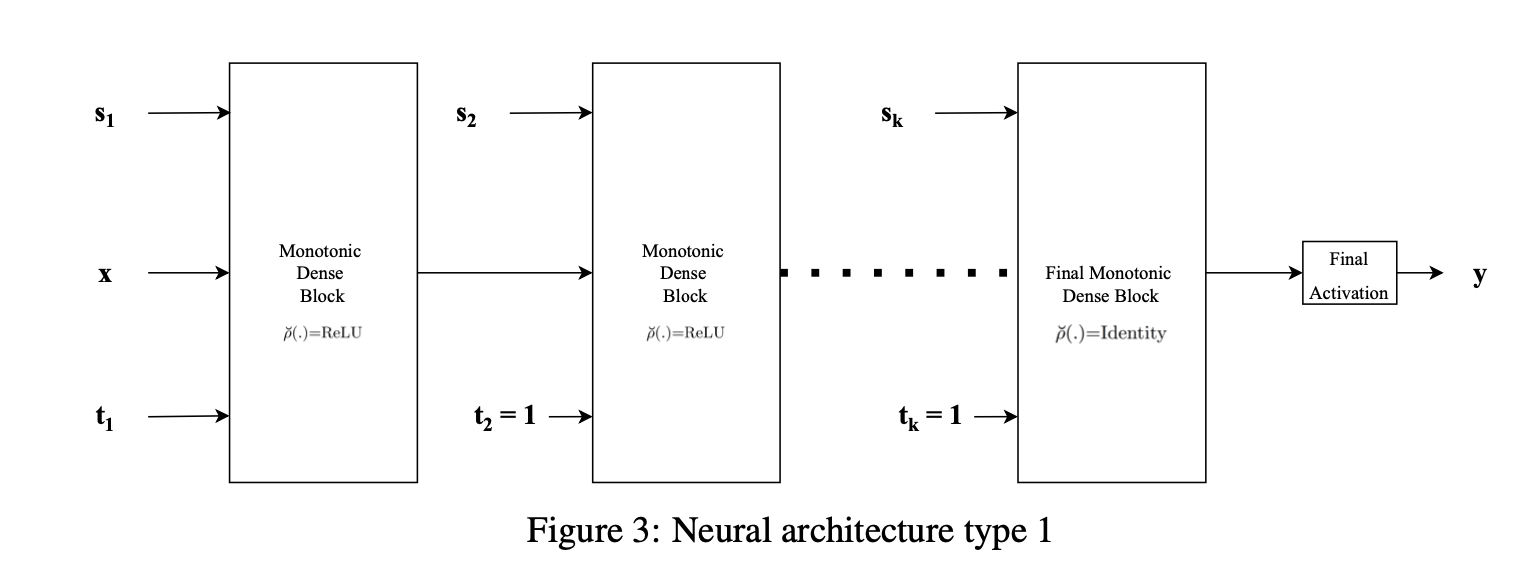

In [25]:
def create_mono_block(
    *,
    units: List[int],
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    monotonicity_indicator: TensorLike = 1,
    is_convex: bool = False,
    is_concave: bool = False,
    dropout: Optional[float] = None,
) -> Callable[[TensorLike], TensorLike]:
    def create_mono_block_inner(
        x: TensorLike,
        *,
        units: List[int] = units,
        activation: Union[str, Callable[[TensorLike], TensorLike]] = activation,
        monotonicity_indicator: TensorLike = monotonicity_indicator,
        is_convex: bool = is_convex,
        is_concave: bool = is_concave,
    ) -> TensorLike:
        if len(units) == 0:
            return x

        y = x
        for i in range(len(units)):
            y = MonotonicDense(
                units=units[i],
                activation=activation if i < len(units) - 1 else None,
                monotonicity_indicator=monotonicity_indicator if i == 0 else 1,
                is_convex=is_convex,
                is_concave=is_concave,
                name=f"mono_dense_{i}"
                + ("_increasing" if i != 0 else "")
                + ("_convex" if is_convex else "")
                + ("_concave" if is_concave else ""),
            )(y)
            if (i < len(units) - 1) and dropout:
                y = Dropout(dropout)(y)

        return y

    return create_mono_block_inner

In [26]:
x = Input(shape=(5, 7, 8))
monotonicity_indicator = [1] * 3 + [0] * 2 + [-1] * 3

mono_block = create_mono_block(
    units=[16] * 3 + [3],
    monotonicity_indicator=monotonicity_indicator,
    activation="elu",
    dropout=0.1,
)
y = mono_block(x)
model = Model(inputs=x, outputs=y)
model.summary()

mono_layers = [layer for layer in model.layers if isinstance(layer, MonotonicDense)]
assert not (mono_layers[0].monotonicity_indicator == 1).all()
for mono_layer in mono_layers[1:]:
    assert (mono_layer.monotonicity_indicator == 1).all()

for mono_layer in mono_layers[:-1]:
    assert mono_layer.org_activation == "elu"
assert mono_layers[-1].org_activation == None

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7, 8)]         0         
                                                                 
 mono_dense_0 (MonotonicDens  (None, 5, 7, 16)         144       
 e)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 7, 16)          0         
                                                                 
 mono_dense_1_increasing (Mo  (None, 5, 7, 16)         272       
 notonicDense)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 5, 7, 16)          0         
                                                                 
 mono_dense_2_increasing (Mo  (None, 5, 7, 16)         272 

In [27]:
def build_monotonic_type1_model(
    *,
    col_names: List[str],
    units: int,
    final_units: int,
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    n_layers: int,
    final_activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    monotonicity_indicator: Union[int, Dict[str, TensorLike]] = 1,
    is_convex: bool = False,
    is_concave: bool = False,
    dropout: Optional[float] = None,
) -> Model:
    # input
    x = [Input(shape=1, name=name) for name in sorted(col_names)]
    y = tf.keras.layers.Concatenate(name="inputs")(x)
    if isinstance(monotonicity_indicator, dict):
        monotonicity_indicator = [
            monotonicity_indicator[name] for name in sorted(col_names)
        ]

    y = create_mono_block(
        units=[units] * (n_layers - 1) + [final_units],
        activation=activation,
        monotonicity_indicator=monotonicity_indicator,
        is_convex=is_convex,
        is_concave=is_concave,
        dropout=dropout,
    )(y)

    if final_activation is not None:
        final_activation = tf.keras.activations.get(final_activation)
        y = final_activation(y)

    model = Model(inputs=x, outputs=y)
    return model

In [28]:
n_layers = 4

model = build_monotonic_type1_model(
    col_names=list("abcd"),
    units=64,
    final_units=10,
    activation="elu",
    n_layers=n_layers,
    final_activation="softmax",
    monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
    is_convex=True,
    dropout=0.1,
)
model.summary()

mono_layers = [layer for layer in model.layers if isinstance(layer, MonotonicDense)]
assert len(mono_layers) == n_layers

# check monotonicity indicator
np.testing.assert_array_equal(
    mono_layers[0].monotonicity_indicator, np.array([1, 0, -1, 0]).reshape((-1, 1))
)
for i in range(1, n_layers):
    assert mono_layers[i].monotonicity_indicator == 1

# check convexity and concavity
for i in range(n_layers):
    assert mono_layers[i].is_convex
    assert not mono_layers[i].is_concave


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            

The function `build_monotonic_type2_model()` can be used to build Neural Network models as shown in the figure below and is referred to in the paper as *Neural architecture type 2*. 

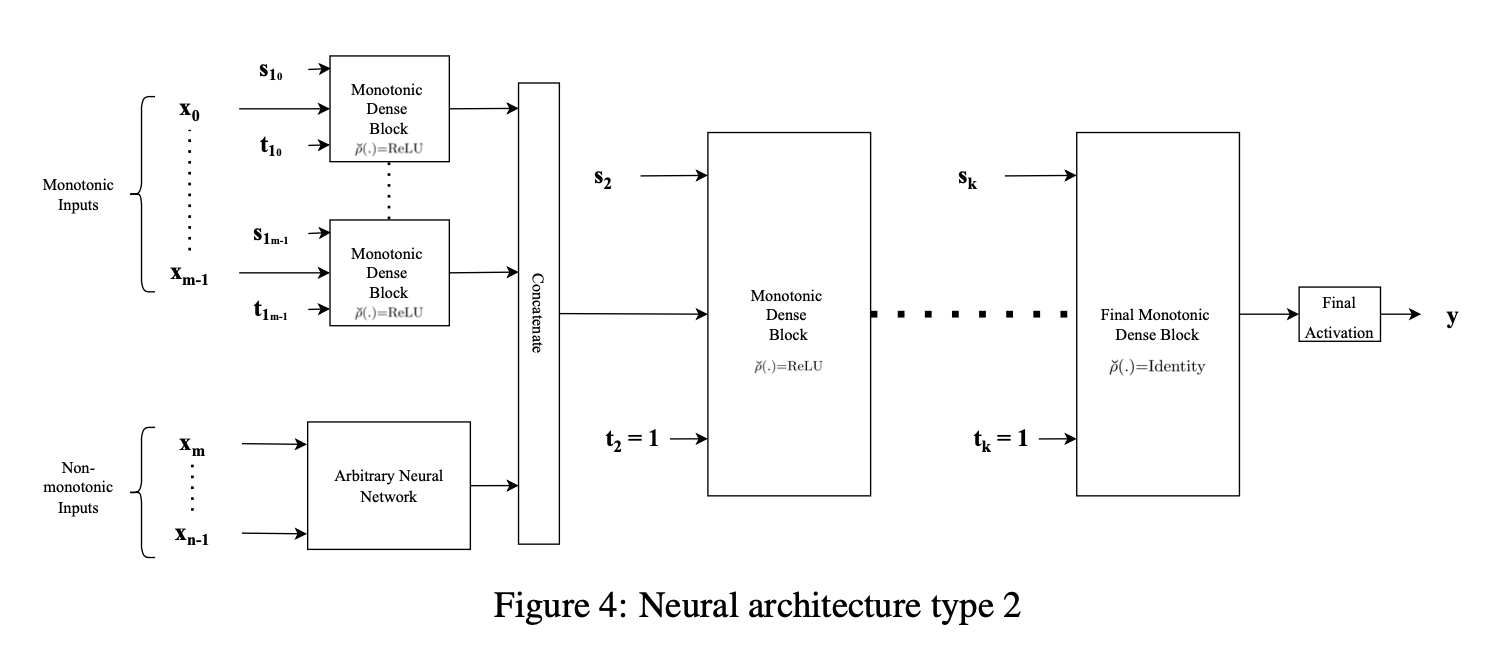

In [29]:
def check_convexity_params(
    names: List[str],
    monotonicity_indicator: Dict[str, int],
    is_convex: Union[bool, Dict[str, bool]] = False,
    is_concave: Union[bool, Dict[str, bool]] = False,
) -> Tuple[Dict[str, bool], Dict[str, bool]]:
    if not isinstance(is_convex, dict):
        is_convex = {k: is_convex for k in names}
    if not isinstance(is_concave, dict):
        is_concave = {k: is_concave for k in names}

    # check keys
    if set(is_convex.keys()) != set(names):
        raise ValueError(f"{set(is_convex.keys())} != {set(names)}")
    if set(is_concave.keys()) != set(names):
        raise ValueError(f"{set(is_concave.keys())} != {set(names)}")

    # check compatibility
    convex_names = set([k for k in names if is_convex[k]])
    concave_names = set([k for k in names if is_concave[k]])
    incompatibles = convex_names.intersection(concave_names)
    if len(incompatibles) > 0:
        raise ValueError(
            f"Inputs {', '.join(sorted(incompatibles))} are set to be both concave and convex!"
        )

    # check monotonicity indicator
    for k, v in monotonicity_indicator.items():
        if v == 0 and (is_concave[k] or is_convex[k]):
            raise ValueError(
                "If monotonicity_indicator is 0, then is_concave and is_convex must be False, "
                + f"but we have: monotonicity_indicator['{k}'] = {monotonicity_indicator[k]}, "
                + f"is_convex['{k}'] = {is_convex[k]}, "
                + f"is_concave['{k}'] = {is_concave[k]}"
            )

    return is_convex, is_concave

In [30]:
names = list("abcd")

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": False, "b": False, "c": False, "d": False},
)
monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, False, False)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
with pytest.raises(ValueError) as e:
    is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, True, False)
assert e.value.args == (
    "If monotonicity_indicator is 0, then is_concave and is_convex must be False, but we have: monotonicity_indicator['a'] = 0, is_convex['a'] = True, is_concave['a'] = False",
)

expected = (
    {"a": True, "b": True, "c": True, "d": True},
    {"a": False, "b": False, "c": False, "d": False},
)
monotonicity_indicator = {"a": -1, "b": 1, "c": 1, "d": -1}
is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, True, False)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
with pytest.raises(ValueError) as e:
    is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, False, True)

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": True, "b": True, "c": True, "d": True},
)
monotonicity_indicator = {"a": -1, "b": 1, "c": 1, "d": -1}
is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, False, True)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

with pytest.raises(ValueError) as e:
    check_convexity_params(names, monotonicity_indicator, True, True)
assert e.value.args == ("Inputs a, b, c, d are set to be both concave and convex!",)

In [31]:
is_convex = {"a": False, "b": False, "c": False, "d": False}
is_concave = False

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": False, "b": False, "c": False, "d": False},
)
monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, is_convex, is_concave)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

is_convex = {"a": False, "b": False, "c": False, "d": False}
is_concave = True

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": True, "b": True, "c": True, "d": True},
)
monotonicity_indicator = {"a": -1, "b": 1, "c": 1, "d": -1}
is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, is_convex, is_concave)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

is_convex = {"a": False, "b": True, "c": False, "d": False}
is_concave = {"a": False, "b": False, "c": True, "d": False}

expected = (
    {"a": False, "b": True, "c": False, "d": False},
    {"a": False, "b": False, "c": True, "d": False},
)
is_convex, is_concave = check_convexity_params(names, monotonicity_indicator, is_convex, is_concave)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

is_convex = {"a": False, "b": True, "c": False, "d": True}
is_concave = {"a": False, "b": False, "c": True, "d": True}

with pytest.raises(ValueError) as e:
    check_convexity_params(names, monotonicity_indicator, is_convex, is_concave)
assert e.value.args == ('Inputs d are set to be both concave and convex!',)

In [32]:
def build_monotonic_type2_model(
    *,
    col_names: List[str],
    input_units: Optional[int] = None,
    units: int,
    final_units: int,
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    n_layers: int,
    final_activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    monotonicity_indicator: Union[int, Dict[str, TensorLike]] = 1,
    is_convex: Union[bool, Dict[str, bool]] = False,
    is_concave: Union[bool, Dict[str, bool]] = False,
    dropout: Optional[float] = None,
):
    if isinstance(monotonicity_indicator, int):
        monotonicity_indicator = {name: monotonicity_indicator for name in col_names}

    if input_units is None:
        input_units = max(units // 4, 1)

    is_convex, is_concave = check_convexity_params(
        col_names, monotonicity_indicator, is_convex, is_concave
    )

    # inputs
    x = {name: Input(shape=1, name=name) for name in col_names}
    inputs = list(x.values())

    y = {
        name: (
            MonotonicDense(
                units=input_units,
                activation=activation,
                monotonicity_indicator=monotonicity_indicator[name],
                is_convex=is_convex[name],
                is_concave=is_concave[name],
                name=f"mono_dense_{name}" + ("_increasing"
                if monotonicity_indicator[name] == 1
                else "_decreasing") + ("_convex"
                if is_convex[name]
                else "") + ("_concave"
                if is_concave[name]
                else ""),
            )
            if monotonicity_indicator[name] != 0
            else Dense(units=input_units, activation=activation, name=f"dense_{name}")
        )(v)
        for name, v in x.items()
    }

    y = Concatenate()([y[k] for k in sorted(col_names)])
    
    if dropout and dropout > 0.0:
        y = Dropout(dropout)(y)
        
    has_convex = any(is_convex.values())
    has_concave = any(is_concave.values())
    if has_convex and has_concave:
        print("WARNING: we have both convex and concave parameters")

    y = create_mono_block(
        units=[units] * (n_layers - 1) + [final_units],
        activation=activation,
        monotonicity_indicator=1,
        is_convex=has_convex,
        is_concave=has_concave and not has_convex,
        dropout=dropout,
    )(y)

    if final_activation is not None:
        final_activation = tf.keras.activations.get(final_activation)
        y = final_activation(y)

    model = Model(inputs=inputs, outputs=y)

    return model

In [33]:
for dropout in [False, True]:
    model = build_monotonic_type2_model(
        col_names=list("abcd"),
        units=32,
        final_units=10,
        activation="elu",
        n_layers=4,
        monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
        is_convex=dict(a=True, b=False, c=False, d=False),
        is_concave=False,
    )
    model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            

## Experiments

For our experiments, we employ the datasets used by the authors of Certified Monotonic Network [1] and COMET [2]. We use the exact train-test split provided by the authors. Their respective repositories are linked below in the references. We directly load the saved train-test data split which have been saved after running the codes from respective papers' authors. 


References:


1.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020
  
  Github repo: https://github.com/gnobitab/CertifiedMonotonicNetwork



2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020

  Github repo: https://github.com/AishwaryaSivaraman/COMET

In [34]:
def sanitize_col_names(df: pd.DataFrame)->pd.DataFrame:
    columns = {c: c.replace(" ", "_") for c in df}
    df = df.rename(columns=columns)
    return df
        

In [35]:
sanitize_col_names(pd.DataFrame({"a b": [1, 2, 3]}))

,a_b
0,1
1,2
2,3


In [36]:
def get_train_n_test_data(
    dataset_name: str, *, data_path: Path = data_path
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_filename = "train_" + dataset_name + ".csv"
    train_df = pd.read_csv(data_path / train_filename)
    test_filename = "test_" + dataset_name + ".csv"
    test_df = pd.read_csv(data_path / test_filename)

    return sanitize_col_names(train_df), sanitize_col_names(test_df)


def df2ds(df: pd.DataFrame) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices(
        (dict(df.drop(columns="ground_truth")), df["ground_truth"])
    )
    return ds


def peek(ds: tf.data.Dataset) -> tf.Tensor:
    for x in ds:
        return x

In [37]:
train_df, test_df = get_train_n_test_data("auto")
peek(df2ds(train_df).batch(8))

({'Cylinders': <tf.Tensor: shape=(8,), dtype=float64, numpy=
  array([1.48280683, 1.48280683, 1.48280683, 1.48280683, 1.48280683,
         1.48280683, 1.48280683, 1.48280683])>,
  'Displacement': <tf.Tensor: shape=(8,), dtype=float64, numpy=
  array([1.07302829, 1.48290248, 1.04443242, 1.0253685 , 2.23592716,
         2.47422611, 2.34077869, 1.8641808 ])>,
  'Horsepower': <tf.Tensor: shape=(8,), dtype=float64, numpy=
  array([0.65056414, 1.54899337, 1.16395227, 0.9072582 , 2.39608379,
         2.96081074, 2.83246371, 2.19072854])>,
  'Weight': <tf.Tensor: shape=(8,), dtype=float64, numpy=
  array([0.60662475, 0.82813104, 0.52341339, 0.54216525, 1.58758116,
         1.60281705, 1.55359343, 1.01213361])>,
  'Acceleration': <tf.Tensor: shape=(8,), dtype=float64, numpy=
  array([-1.27554616, -1.45251749, -1.27554616, -1.80646013, -1.98343145,
         -2.3373741 , -2.51434542, -2.51434542])>,
  'Model_Year': <tf.Tensor: shape=(8,), dtype=float64, numpy=
  array([-1.63180251, -1.63180251, -

In [38]:
# def train_dataset(
#     dataset_name: str,
#     monotonicity_indicator: Optional[NDArray],
# #     convexity_indicator: Optional[NDArray],
#     train_params: Dict[str, Any],
# ):

#     train_df, test_df = get_train_n_test_data(
#         data_path=data_path, dataset_name=dataset_name
#     )

#     train_df, y_train = get_feats_n_gt(train_df)
#     test_df, y_test = get_feats_n_gt(test_df)

#     col_names = train_df.columns.to_list()

#     batch_size = train_params["batch_size"]
#     num_epochs = train_params["num_epochs"]
#     units = train_params["units"]
#     n_layers = train_params["n_layers"]
#     activation = train_params["activation"]
#     loss = train_params["loss"]
#     metrics = train_params["metrics"]
#     learning_rate = train_params["learning_rate"]
#     is_classification = train_params["is_classification"]

#     monotonic_model = build_monotonic_type2_model(
#         units=units,
#         n_layers=n_layers,
#         activation=activation,
#         is_classification=is_classification,
#         col_names=col_names,
#         monotonicity_indicator=monotonicity_indicator,
# #         convexity_indicator=convexity_indicator,
#     )
#     train_ds = tf.data.Dataset.from_tensor_slices((dict(train_df), y_train))
#     test_ds = tf.data.Dataset.from_tensor_slices((dict(test_df), y_test))

#     train_ds = train_ds.batch(batch_size)
#     val_ds = test_ds.batch(batch_size)

#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     monotonic_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#     history = monotonic_model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)

#     return history, monotonic_model

### Comparison with methods and datasets from COMET [1] (Reference #20 in our paper)


References:


1.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020

  Github repo: https://github.com/AishwaryaSivaraman/COMET



#### Experiment for Auto MPG dataset

The Auto MPG Dataset is a regression dataset [1] with 7 features - Cylinders, Displacement, Horsepower,Weight, Acceleration, Model Year, Origin. And the dependant variable is monotonically decreasing with
respect to features weigh, displacement, and horsepower. The `monotonicity_indicator` corrsponding to these features are set to -1, since the relationship is a monotonically decreasing one with respect to the dependant variable.



References:

1. Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
 
  https://archive.ics.uci.edu/ml/datasets/auto+mpg

2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020


In [39]:
auto_train_df, auto_test_df = get_train_n_test_data(
    data_path=data_path, dataset_name="auto"
)
display(auto_train_df)
# display(test_df)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,ground_truth
0,1.482807,1.073028,0.650564,0.606625,-1.275546,-1.631803,-0.701669,18.0
1,1.482807,1.482902,1.548993,0.828131,-1.452517,-1.631803,-0.701669,15.0
2,1.482807,1.044432,1.163952,0.523413,-1.275546,-1.631803,-0.701669,16.0
3,1.482807,1.025368,0.907258,0.542165,-1.806460,-1.631803,-0.701669,17.0
4,1.482807,2.235927,2.396084,1.587581,-1.983431,-1.631803,-0.701669,15.0
...,...,...,...,...,...,...,...,...
309,0.310007,0.358131,0.188515,-0.177437,-0.319901,1.720778,-0.701669,22.0
310,-0.862792,-0.566468,-0.530229,-0.722413,-0.921604,1.720778,-0.701669,36.0
311,-0.862792,-0.928683,-1.351650,-1.003691,3.184131,1.720778,0.557325,44.0
312,-0.862792,-0.566468,-0.530229,-0.810312,-1.417123,1.720778,-0.701669,32.0


In [40]:
auto_train_ds = df2ds(auto_train_df).repeat(10).shuffle(10 * auto_train_df.shape[0]).batch(16)
auto_test_ds = df2ds(auto_test_df).batch(16)

peek(auto_train_ds), len(auto_train_ds)

(({'Cylinders': <tf.Tensor: shape=(16,), dtype=float64, numpy=
   array([ 1.48280683, -0.86279189, -0.86279189, -0.86279189, -0.86279189,
           0.31000747, -0.86279189, -0.86279189, -0.86279189,  1.48280683,
           0.31000747,  0.31000747, -0.86279189,  0.31000747,  1.48280683,
          -0.86279189])>,
   'Displacement': <tf.Tensor: shape=(16,), dtype=float64, numpy=
   array([ 1.04443242, -0.98587462, -0.74757568, -0.41395715, -0.8333633 ,
           0.34859949, -1.03353441, -0.69991589, -1.20510966,  1.95950038,
           0.35813144,  0.05310879, -0.69991589,  0.52970669,  1.95950038,
          -0.41395715])>,
   'Horsepower': <tf.Tensor: shape=(16,), dtype=float64, numpy=
   array([ 1.16395227, -0.94093908, -0.37621213, -0.42755095, -0.76125323,
           0.00882897, -1.0179473 , -0.17085688, -1.42865781,  1.16395227,
          -0.11951807, -0.60723679,  0.21418422, -0.83826145,  1.60033218,
          -0.42755095])>,
   'Weight': <tf.Tensor: shape=(16,), dtype=float64, n

In [41]:
def build_auto_model_f(
    *,
    units: int,
    n_layers: int,
    activation: str,
    learning_rate: float,
    weight_decay: float,
    dropout: float,
    decay_rate: float,
) -> Model:
    monotonicity_indicator = {
        "Cylinders": 0,
        "Displacement": -1,
        "Horsepower": -1,
        "Weight": -1,
        "Acceleration": 0,
        "Model_Year": 0,
        "Origin": 0,
    }

    model = build_monotonic_type2_model(
        col_names=list(monotonicity_indicator.keys()),
        units=units,
        final_units=1,
        activation=activation,
        n_layers=n_layers,
        monotonicity_indicator=monotonicity_indicator,
        is_convex=False,
        is_concave=False,
        dropout=dropout,
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate, decay_steps=197, decay_rate=decay_rate, staircase=True
    )

    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=weight_decay)
    metrics = tf.keras.metrics.MeanSquaredError()
    loss = "mse"
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model



In [42]:
auto_model = build_auto_model_f(units=48, n_layers=1, activation="elu", dropout=0.25, weight_decay=0.005, learning_rate=0.1, decay_rate=0.95)
auto_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Acceleration (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 Cylinders (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Displacement (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 Horsepower (InputLayer)        [(None, 1)]          0           []                               
                                                                                            

In [43]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
auto_model.fit(
    auto_train_ds,
    validation_data=auto_test_ds,
    callbacks=[stop_early],
    epochs=10,
)

Epoch 1/10
197/197 [==============================] - 11s 12ms/step - loss: 28.3051 - mean_squared_error: 28.3051 - val_loss: 9.6403 - val_mean_squared_error: 9.6403
Epoch 2/10
197/197 [==============================] - 2s 12ms/step - loss: 14.9211 - mean_squared_error: 14.9211 - val_loss: 12.1920 - val_mean_squared_error: 12.1920
Epoch 3/10
197/197 [==============================] - 2s 11ms/step - loss: 14.2464 - mean_squared_error: 14.2464 - val_loss: 13.2106 - val_mean_squared_error: 13.2106
Epoch 4/10
197/197 [==============================] - 2s 10ms/step - loss: 12.8591 - mean_squared_error: 12.8591 - val_loss: 12.3133 - val_mean_squared_error: 12.3133


In [44]:
def get_exponents(start: int, end: int = 0):
    return sorted(
        [float(f"1.e{i}") for i in range(start, end + 1)]
        + [float(f"2.e{i}") for i in range(start, end)]
        + [float(f"5.e{i}") for i in range(start, end)]
    )


def build_auto_model(hp) -> Model:
    return build_auto_model_f(
        units=hp.Int("units", min_value=16, max_value=96, step=16),
        n_layers=hp.Int("n_layers", min_value=1, max_value=3),
        activation=hp.Choice("activation", values=["relu", "elu"]),
        learning_rate=hp.Choice("learning_rate", values=get_exponents(-3, 0)),
        weight_decay=hp.Choice("weight_decay", values=get_exponents(-3, 0)),
        dropout=hp.Choice("dropout", values=[0.0, 0.1, 0.25, 0.5]),
        decay_rate=hp.Choice("decay_rate", values=[0.6, 0.8, 0.9, 0.95]),
    )

In [45]:
def find_hyperparameters(
    build_model_f: Callable[..., Model],
    *,
    max_epochs: int,
    train_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
    objective: Union[str, Objective],
    dir_root: Union[Path, str],
    project_name: str,
    factor: int = 2,
    seed: int = 42,
    executions_per_trial: int = 1,
    hyperband_iterations: int = 1,
    max_consecutive_failed_trials: int = 5,
) -> Tuner:
    tuner = Hyperband(
        build_model_f,
        objective=objective,
        max_epochs=max_epochs,
        factor=factor,
        seed=seed,
        directory=Path(dir_root) / datetime.now().isoformat(),
        project_name=project_name,
        executions_per_trial=executions_per_trial,
        hyperband_iterations=hyperband_iterations,
        max_consecutive_failed_trials=max_consecutive_failed_trials,
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
    tuner.search(
        train_ds,
        validation_data=test_ds,
        callbacks=[stop_early],
    )

    return tuner

In [ ]:
auto_tuner = find_hyperparameters(
    build_auto_model,
    train_ds=auto_train_ds,
    test_ds=auto_test_ds,
    objective=Objective("val_mean_squared_error", direction="min"),
    max_epochs=10,
    hyperband_iterations=10,
    executions_per_trial=2,
    dir_root="/tmp/tuner/auto_tuner",
    project_name="auto_tuner",
)

Trial 16 Complete [00h 00m 15s]
val_mean_squared_error: 9.174154281616211

Best val_mean_squared_error So Far: 9.035600662231445
Total elapsed time: 00h 04m 02s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
96                |80                |units
1                 |3                 |n_layers
relu              |relu              |activation
0.005             |0.005             |learning_rate
0.5               |0.05              |weight_decay
0.1               |0                 |dropout
0.8               |0.8               |decay_rate
5                 |2                 |tuner/epochs
3                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2                 |0                 |tuner/round
0011              |None              |tuner/trial_id

Epoch 4/5
197/197 [==============================] - 5s 9ms/step - loss: 8.6878 - mean_squared_error: 8.6878 - val_loss: 9.5888 - val_mean_squared_error: 9

In [ ]:
def count_model_params(model: Model) -> int:
  return sum([sum([count_params(v) for v in l.variables]) for l in model.layers])
  
def create_model_stats(
    tuner: Hyperband,
    hp: Dict[str, Any],
    *,
    epochs: int,
    num_runs: int = 10,
    train_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
) -> pd.DataFrame:
    def model_stats(
        tuner: Hyperband = tuner,
        hp: Dict[str, Any] = hp,
        epochs: int = epochs,
        train_ds: tf.data.Dataset = train_ds,
        test_ds: tf.data.Dataset = test_ds,
    ) -> Dict[str, Any]:
        model = tuner.hypermodel.build(hp)
        history = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=0)
        objective = history.history[tuner.oracle.objective.name]
        if tuner.oracle.objective.direction == "max":
            best_epoch = objective.index(max(objective))
        else:
            best_epoch = objective.index(min(objective))
        return objective[best_epoch]

#     print(f"Running stats for params: {hp.values}")
    stats = pd.Series([model_stats() for _ in range(num_runs)])
    stats = stats.describe()
    stats = {f"{tuner.oracle.objective.name}_{k}": stats[k] for k in ["mean", "std"]}
    model = tuner.hypermodel.build(hp)
    stats = pd.DataFrame(dict(**hp.values, **stats, params=count_model_params(model)), index=[0])
#     display(stats)
    return stats


def create_tuner_stats(
    tuner: Hyperband,
    *,
    epochs: int,
    num_runs: int = 10,
    num_models: int = 5,
    train_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
) -> pd.DataFrame:
    stats = None
    
    for hp in tuner.get_best_hyperparameters(num_trials=num_models):
        new_entry = create_model_stats(
            tuner,
            hp,
            epochs=epochs,
            num_runs=num_runs,
            train_ds=train_ds,
            test_ds=test_ds,
        )
        if stats is None:
            stats = new_entry
        else:
            stats = pd.concat([stats, new_entry]).reset_index(drop=True).sort_values(f"{tuner.oracle.objective.name}_mean")
            
        display(stats)

    return stats

In [ ]:
%%time

auto_stats = create_tuner_stats(
    auto_tuner,
    epochs=10,
    num_runs=10,
    num_models=20,
    train_ds=train_ds,
    test_ds=test_ds,
)

auto_stats

In [ ]:
auto_stats

In [ ]:
assert False

In [ ]:
tuner.remaining_trials

In [ ]:
model_params = dict(
    units=32,
    n_layers=3,
    activation="elu",
    learning_rate=0.028,
    weight_decay=1e-1,
)
train_params = dict(
    batch_size=16,
    num_epochs=20,
)
model = build_auto_model_f(**model_params)
model.summary()

In [ ]:
model.fit(train_ds.shuffle(1_000).batch(16), validation_data=test_ds.batch(16), epochs=20)

In [ ]:
train_params = dict(
    batch_size=16,
    num_epochs=20,
    loss="mse",
    metrics="rmse",
    learning_rate=0.028,
    is_classification=False,
)



In [ ]:
tf.keras.utils.set_random_seed(42)

monotonicity_indicator = np.array([0, -1, -1, -1, 0, 0, 0])

# convexity_indicator = None


history, monotonic_model = train_dataset(
    dataset_name="auto",
    monotonicity_indicator=monotonicity_indicator,
#     convexity_indicator=convexity_indicator,
    train_params=train_params,
)

#### Experiment for  Heart Disease  Dataset [1]



Heart Disease [1] is a classification dataset
used for predicting the presence of heart disease with 13 features (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal)   and monotonically increasing with respect to features- trestbps and cholestrol (chol). The `monotonicity_indicator` corrsponding to these features are set to 1. 



References:


1.   John H. Gennari, Pat Langley, and Douglas H. Fisher. Models of incremental concept formation. Artif. Intell., 40(1-3):11–61, 1989.

  https://archive.ics.uci.edu/ml/datasets/heart+disease

2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020



In [ ]:
tf.keras.utils.set_random_seed(42)

monotonicity_indicator = np.array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

convexity_indicator = None

train_params = dict(
    batch_size=32,
    num_epochs=1,
    units=48,
    n_layers=1,
    activation="elu",
    loss="binary_crossentropy",
    metrics="accuracy",
    learning_rate=0.01,
    is_classification=True,
)

history, monotonic_model = train_dataset(
    dataset_name="heart",
    monotonicity_indicator=monotonicity_indicator,
#     convexity_indicator=convexity_indicator,
    train_params=train_params,
)

![Screenshot%202023-01-26%20at%2015.15.44.png](attachment:Screenshot%202023-01-26%20at%2015.15.44.png)

The figure above shows the table from our paper for reference. As can be seen from our experiments above, our proposed methodology performs comparable to or better than state-of-the-art

### Comparison with methods and datasets from Certified Monotonic Network [1] (Reference #20 in our paper)


References:


1.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020



#### Experiment for Compas Dataset [1]

COMPAS [1] is a dataset containing the criminal records of 6,172 individuals
arrested in Florida. The task is to predict whether the individual will commit a crime again
in 2 years. The probability predicted by the system will be used as a risk score. As mentioned in [2] 13 attributes for prediction. The risk score should be monotonically increasing w.r.t. four attributes, number of prior adult convictions, number of juvenile felony, number of juvenile misdemeanor, and number of other convictions. The `monotonicity_indicator` corrsponding to these features are set to 1.

References: 

1. S. Mattu J. Angwin, J. Larson and L. Kirchner. Machine bias: There’s software used across the country to predict future criminals. and it’s biased against blacks. ProPublica, 2016.

2. Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020


In [ ]:
tf.keras.utils.set_random_seed(42)

monotonicity_indicator = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# convexity_indicator = None

train_params = dict(
    batch_size=64,
    num_epochs=2,
    units=16,
    n_layers=2,
    activation="relu",
    loss="binary_crossentropy",
    metrics="accuracy",
    learning_rate=0.028,
    is_classification=True,
)


history, monotonic_model = train_dataset(
    dataset_name="compas",
    monotonicity_indicator=monotonicity_indicator,
#     convexity_indicator=convexity_indicator,
    train_params=train_params,
)

#### Experiment for Blog Dataset [1]

Blog Feedback [1] is a dataset containing 54,270 data points from
blog posts. The raw HTML-documents of the blog posts were crawled and processed. The prediction
task associated with the data is the prediction of the number of comments in the upcoming 24 hours.
The feature of the dataset has 276 dimensions, and 8 attributes among them should be monotonically
non-decreasing with the prediction. They are A51, A52, A53, A54, A56, A57, A58, A59. Thus the `monotonicity_indicator` corrsponding to these features are set to 1.  As done in [2], we only use the data points with targets smaller than the 90th percentile.




References:

1.   Krisztian Buza. Feedback prediction for blogs. In Data analysis, machine learning and knowledge discovery, pages 145–152. Springer, 2014
2.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020



In [ ]:
tf.keras.utils.set_random_seed(42)

monotonicity_indicator = np.zeros((276))
monotonicity_indicator[50:54] = 1.0
monotonicity_indicator[55:59] = 1.0

# convexity_indicator = None

train_params = dict(
    batch_size=256,
    num_epochs=100,
    units=4,
    n_layers=2,
    activation="elu",
    loss="mean_squared_error",
    metrics=tf.keras.metrics.RootMeanSquaredError(),
    learning_rate=0.01,
    is_classification=False,
)


history, monotonic_model = train_dataset(
    dataset_name="blog",
    monotonicity_indicator=monotonicity_indicator,
#     convexity_indicator=convexity_indicator,
    train_params=train_params,
)

#### Experiment for Loan  Dataset [1]

Lending club loan *data*
contains complete loan data for all loans
issued through 2007-2015 of several banks. Each data point is a 28-dimensional feature including
the current loan status, latest payment information, and other additional features. The task is to
predict loan defaulters given the feature vector. The possibility of loan default should be nondecreasing w.r.t. number of public record bankruptcies, Debt-to-Income ratio, and
non-increasing w.r.t. credit score, length of employment, annual income. Thus the `monotonicity_indicator` corrsponding to these features are set to 1.


References:

1. https://www.kaggle.com/wendykan/lending-club-loan-data (Note: Currently, the dataset seems to be withdrawn from kaggle)

In [ ]:
tf.keras.utils.set_random_seed(42)

# monotonicity_indicator = np.array([-1,  1, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
#   0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
monotonicity_indicator = np.array([-1, 1, -1, -1, 1] + [0] * 24)

convexity_indicator = None

train_params = dict(
    batch_size=256,
    num_epochs=20,
    units=4,
    n_layers=1,
    activation="elu",
    loss="binary_crossentropy",
    metrics="accuracy",
    learning_rate=0.008,
    is_classification=True,
)


history, monotonic_model = train_dataset(
    dataset_name="loan",
    monotonicity_indicator=monotonicity_indicator,
#     convexity_indicator=convexity_indicator,
    train_params=train_params,
)

The figure above shows the table from our paper for reference. As can be seen from our experiments above, our proposed methodology performs comparable to or better than state-of-the-art

![Screenshot%202023-01-26%20at%2015.15.52.png](attachment:Screenshot%202023-01-26%20at%2015.15.52.png)